In [33]:
%matplotlib inline
#%matplotlib notebook
#https://drive.google.com/drive/folders/1qAN0YS7cR978CSuFOtIhAzv9RN_wBfbT

In [34]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import numpy as np
from numpy import median
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

sets the conditions of the tube

In [35]:
inputs = [

    # 1,9,17  Wt:W    
    # 2,10,18 Lux:W   
    # 3,11,19 Las:W   
    # 4,12,20 Tra:W   
    # 5,13,21 LuxR:LasI
    # 6,14,22 LuxR:LuxI
    # 7,15,23 LasR:LasI
    # 8,16,24 TraR:TraI


    
    ["LuxR_LuxI_Tube_001.fcs",'WT','none','0','1'],
    
    
    ["Coculture 24h_Tube"+"_003"+".fcs",'LasR','W','24','1'],
    ["Coculture 24h_Tube"+"_011"+".fcs",'LasR','W','24','2'],
    ["Coculture 24h_Tube"+"_019"+".fcs",'LasR','W','24','3'],
    
    ["Coculture 24h_Tube"+"_007"+".fcs",'LasR','LasI','24','1'],
    ["Coculture 24h_Tube"+"_015"+".fcs",'LasR','LasI','24','2'],
    ["Coculture 24h_Tube"+"_023"+".fcs",'LasR','LasI','24','3'],
    
    ["Coculture 48h_Tube"+"_003"+".fcs",'LasR','W','48','1'],
    ["Coculture 48h_Tube"+"_011"+".fcs",'LasR','W','48','2'],
    ["Coculture 48h_Tube"+"_019"+".fcs",'LasR','W','48','3'],
    
    ["Coculture 48h_Tube"+"_007"+".fcs",'LasR','LasI','48','1'],
    ["Coculture 48h_Tube"+"_015"+".fcs",'LasR','LasI','48','2'],
    ["Coculture 48h_Tube"+"_023"+".fcs",'LasR','LasI','48','3'],
    
    


]

       
tubes = []
for filename, Rprotein, Iprotein, hours,REP in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'Rprotein' : Rprotein, 'Iprotein' : Iprotein, 'Hours' : hours, 'REP' : REP }))
    
ex = flow.ImportOp(conditions = {'Rprotein' : 'str', 'Iprotein' : 'str', 'Hours' : 'float','REP' : 'float'},
                   tubes = tubes).apply()
    


In [36]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


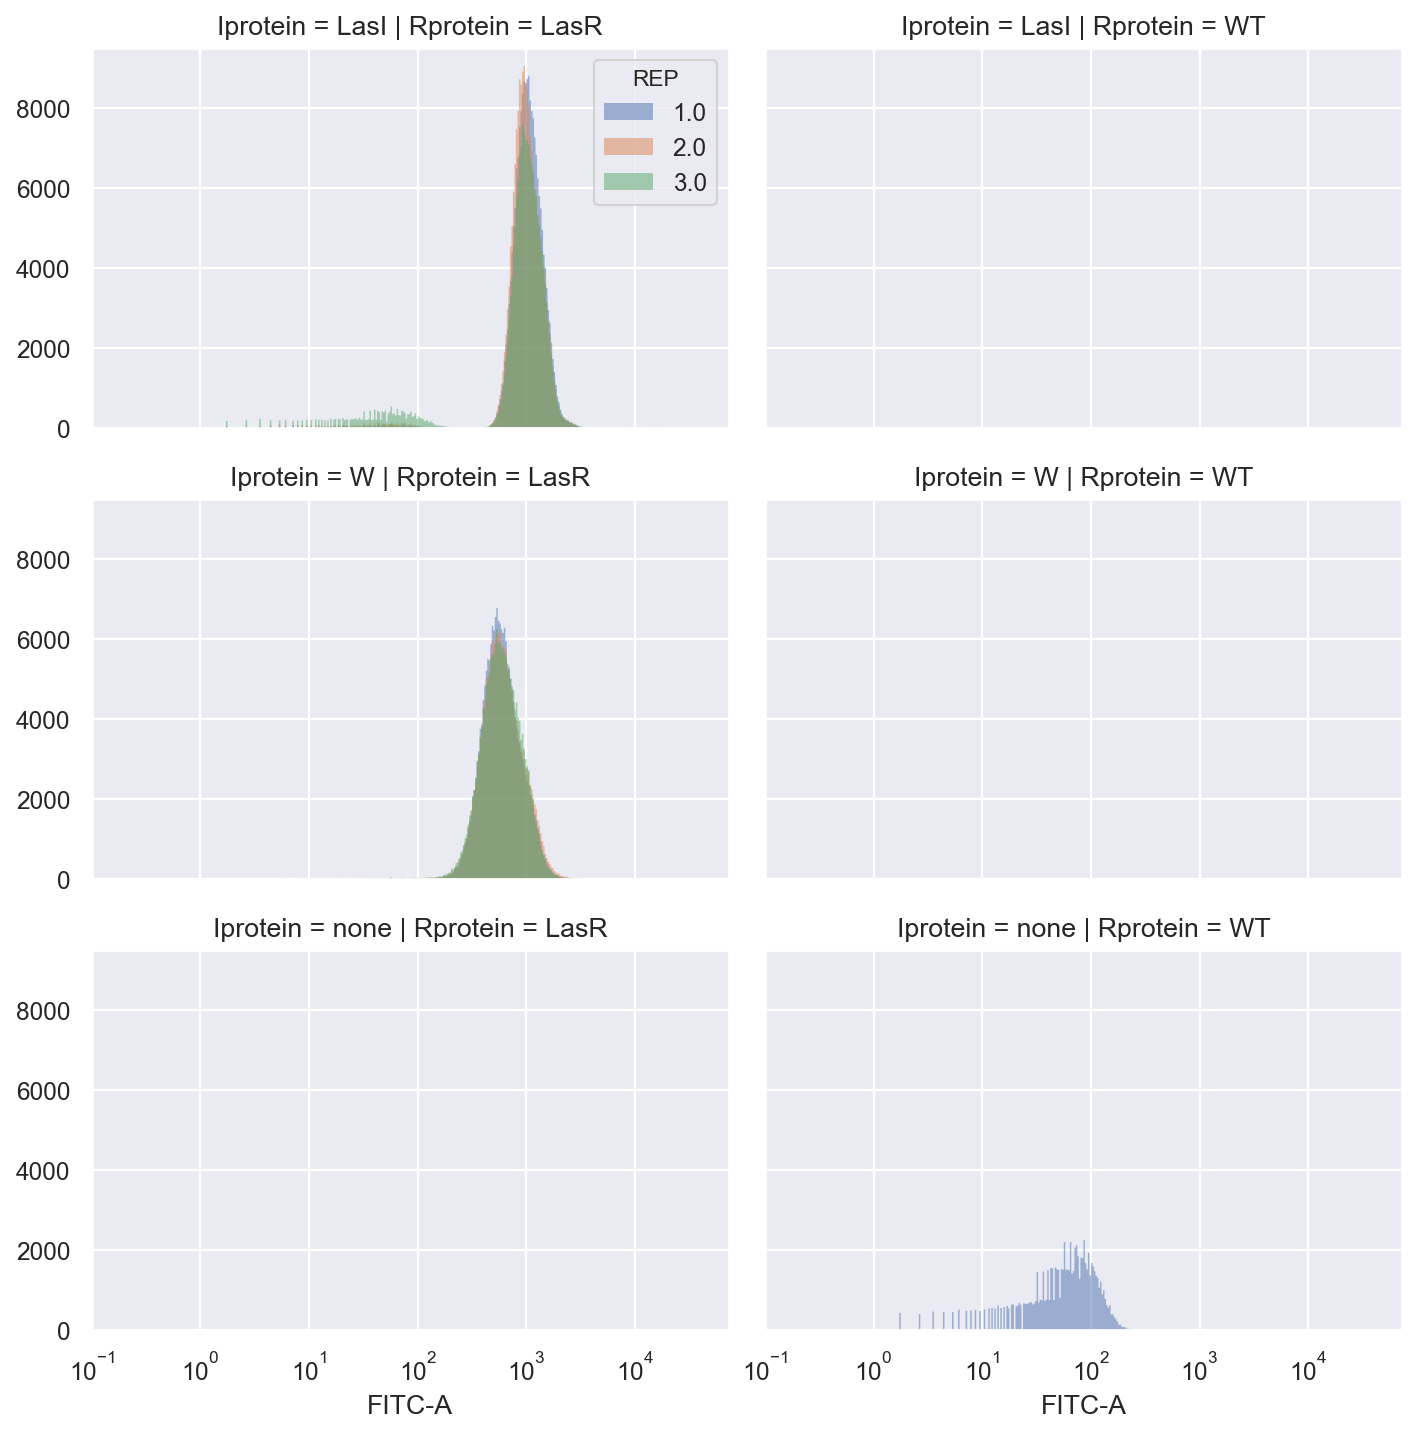

In [37]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = 'Rprotein',
                  yfacet = 'Iprotein',
                  huefacet = 'REP').plot(ex)


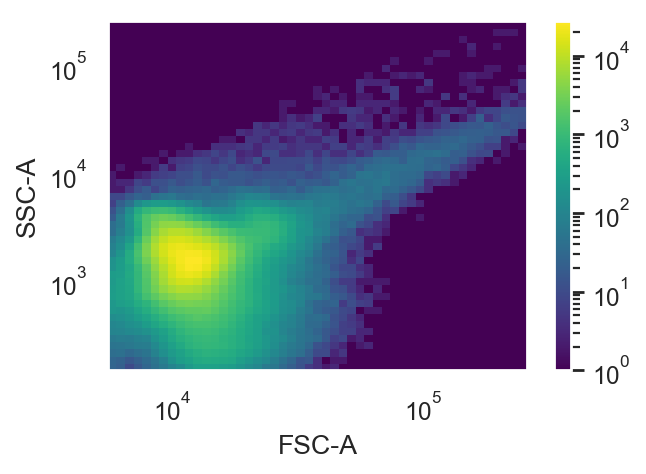

In [38]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

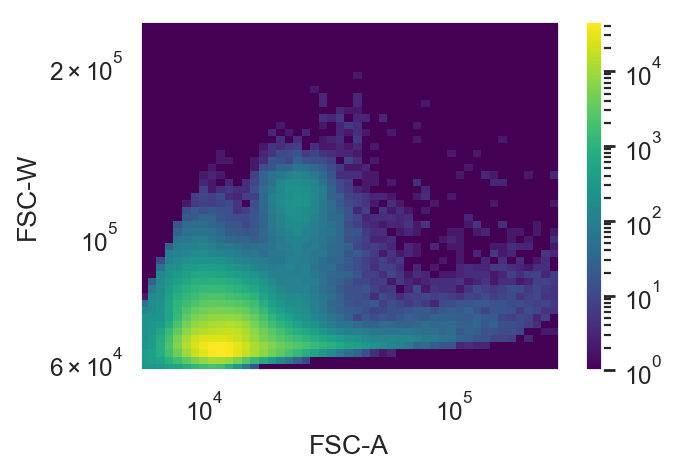

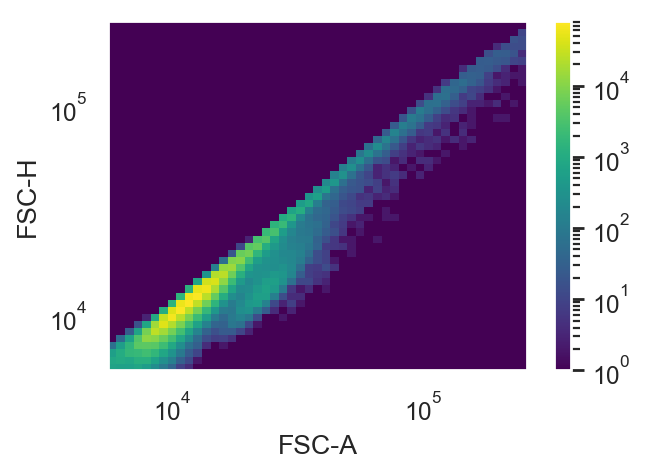

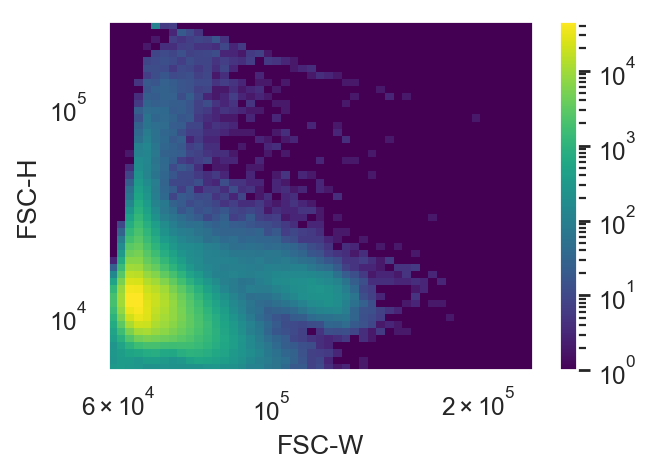

In [39]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


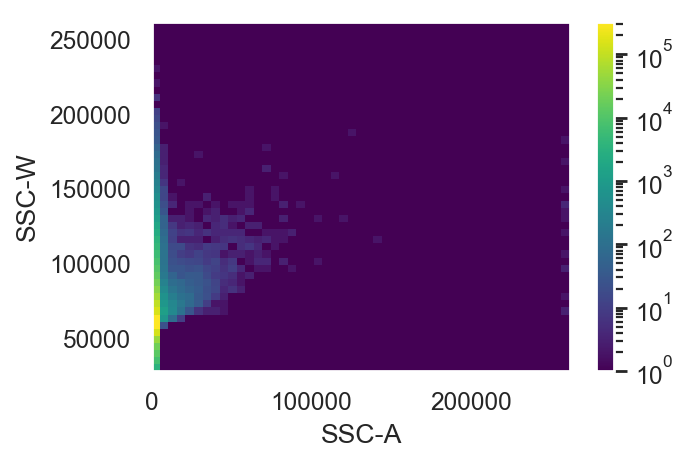

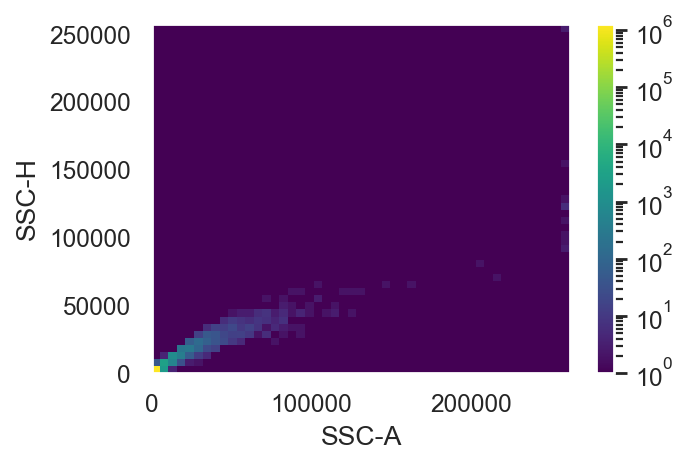

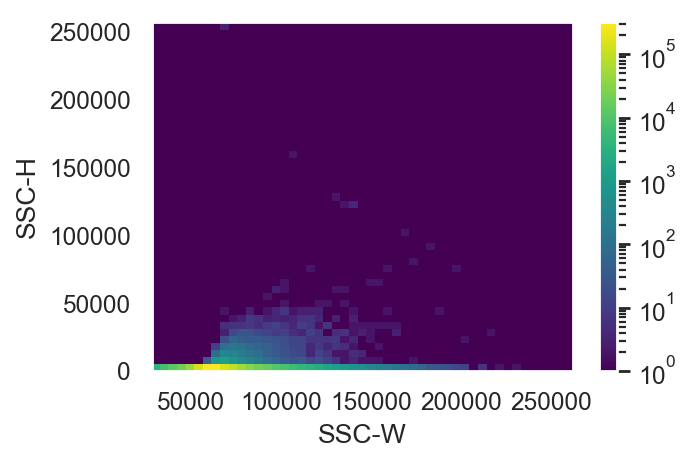

In [40]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

saves the single data as ex2

In [41]:
Chlorophyl = flow.Range2DOp(name = "Chlorophyl",
                   xchannel = "PerCP-Cy5-5-A",
                   xlow = 2000,
                   xhigh = 90000,
                   ychannel = "SSC-A",
                   ylow = 100,
                   yhigh = 15000)
                   
Chlorophylv = Chlorophyl.default_view(xscale ='log',yscale='log')

ex = Chlorophyl.apply(ex)
ex.data.groupby('Chlorophyl').size()

Chlorophyl
False      37042
True     1262958
dtype: int64

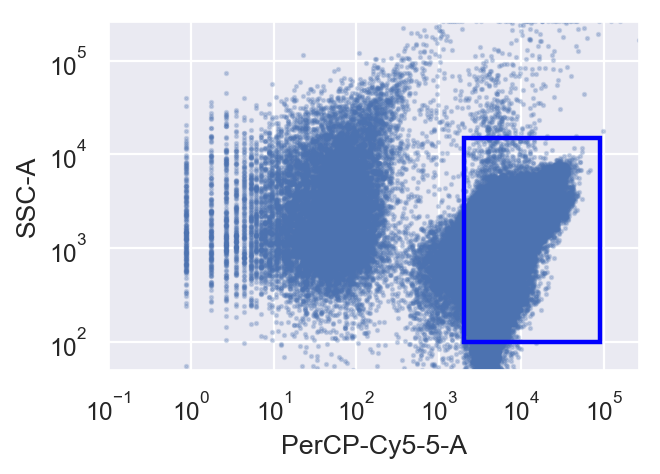

In [42]:
Chlorophylv.plot(ex)

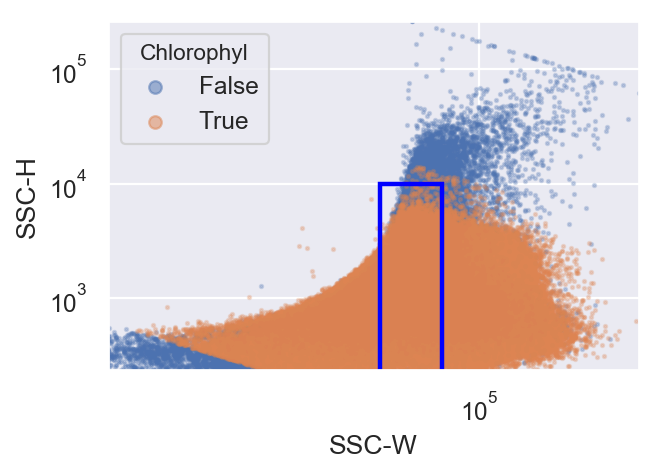

In [43]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 80000,
                   ychannel = "SSC-H",
                   ylow = 100,
                   yhigh = 10000)
                   
rv = r.default_view(xscale ='log',yscale='log',huefacet = 'Chlorophyl')

rv.plot(ex)
ex = r.apply(ex)

In [44]:
ex.data.groupby('Range2D').size()

Range2D
False     283879
True     1016121
dtype: int64

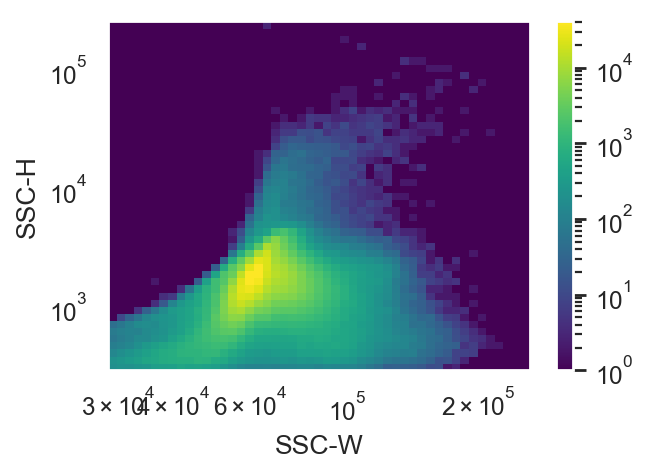

In [45]:
flow.DensityView(xchannel = "SSC-W", 
                 ychannel = "SSC-H",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


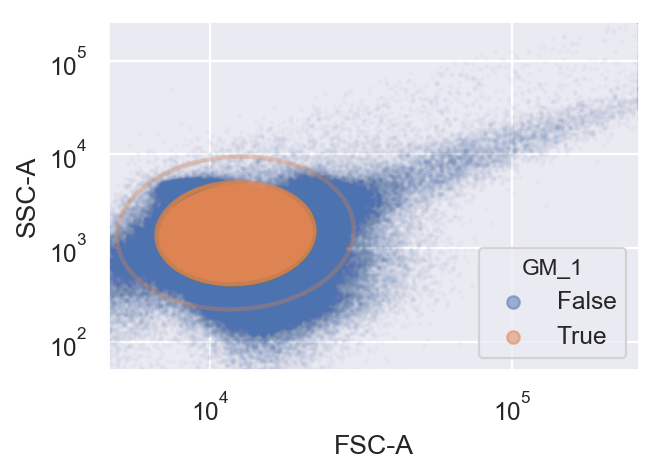

In [46]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex)
ex = gm.apply(ex)
gm.default_view().plot(ex, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


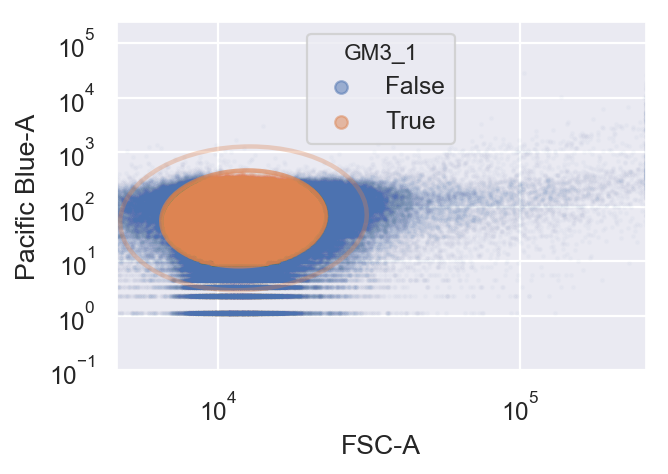

In [47]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex)
ex = gm3.apply(ex)
gm3.default_view().plot(ex, alpha = 0.02)

In [48]:
df =ex.data

In [49]:
ex.data.head()

,AmCyan-A,AmCyan-H,AmCyan-W,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,Hours,...,REP,Rprotein,SSC-A,SSC-H,SSC-W,Time,Chlorophyl,Range2D,GM_1,GM3_1
0,23.940001,91.0,17241.011719,-1.760000,92.0,0.000000,10310.520508,10552.0,64036.226562,0.0,...,1.0,WT,1342.000000,1452.0,60571.152344,52.500000,True,True,True,False
1,36.480000,118.0,20260.621094,70.400002,55.0,83886.085938,11392.379883,11610.0,64307.582031,0.0,...,1.0,WT,1846.239990,1872.0,64634.179688,52.599998,True,True,True,True
2,-96.900002,54.0,0.000000,101.199997,37.0,179249.796875,9765.209961,10033.0,63786.785156,0.0,...,1.0,WT,1520.640015,1602.0,62207.656250,52.599998,True,True,True,False
3,50.160000,58.0,56677.343750,48.400002,90.0,35243.804688,7499.290039,7742.0,63481.457031,0.0,...,1.0,WT,1004.960022,1098.0,59982.750000,52.599998,True,True,True,False
4,55.860001,93.0,39363.882812,51.919998,112.0,30380.615234,10060.860352,10372.0,63570.050781,0.0,...,1.0,WT,1283.920044,1376.0,61150.425781,52.599998,True,True,True,False


take the stuff from cytoflow and changing it to datatframe

# filter out events that don't fall within the gates

In [50]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df.Chlorophyl==True) & (df['FITC-A'] >0)] 
#df
# 

In [51]:
#f, ax = plt.subplots()
#sns.kdeplot(x='SSC-W',y='SSC-H',data=df[['SSC-W', 'SSC-H']],ax=ax)

In [52]:
df.columns 



Index(['AmCyan-A', 'AmCyan-H', 'AmCyan-W', 'FITC-A', 'FITC-H', 'FITC-W',
       'FSC-A', 'FSC-H', 'FSC-W', 'Hours', 'Iprotein', 'Pacific Blue-A',
       'Pacific Blue-H', 'Pacific Blue-W', 'PerCP-Cy5-5-A', 'PerCP-Cy5-5-H',
       'PerCP-Cy5-5-W', 'REP', 'Rprotein', 'SSC-A', 'SSC-H', 'SSC-W', 'Time',
       'Chlorophyl', 'Range2D', 'GM_1', 'GM3_1'],
      dtype='object')

In [60]:
# Subtract WT background from samples
data = df[['FITC-A','Rprotein','Iprotein','Hours','REP']]
data.loc[:,'FITC-A'] = data.loc[:,'FITC-A'] - data.loc[data.Rprotein=='WT','FITC-A'].median()
data.loc[:,'FITC-A'] = data.loc[data['FITC-A'] > 0,'FITC-A']
data.loc[:,'Replicate'] = 1
data.to_pickle(r'../../../../compiled-data/Figure 5/Las1.pkl')

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
data['FITC-A'].min()

0.8800010681152344

1            10.560001
11            7.920002
12           20.240002
15           16.719997
17           29.039997
19           51.039997
24           19.359997
25            0.880001
31           46.639996
35           28.160000
39            9.679996
40            8.799999
41           23.759998
45            9.679996
50           21.999996
53           26.399998
58           29.039997
71           14.960003
76            7.920002
77           14.079998
79           15.840000
81           44.880001
89           24.639996
111          12.319996
112          67.759998
115          41.359997
121          27.280003
135          36.960003
136         117.919994
139          67.759998
              ...     
1299877     949.519985
1299882    1545.279995
1299885    1192.399990
1299889     993.519985
1299890    1027.840054
1299894     865.040005
1299906    1391.279995
1299911    1126.399990
1299925    1034.879971
1299926     802.560024
1299933    1142.239956
1299937    1325.279995
1299940    

# Plot median FITC-A

use median or geometeric mean 

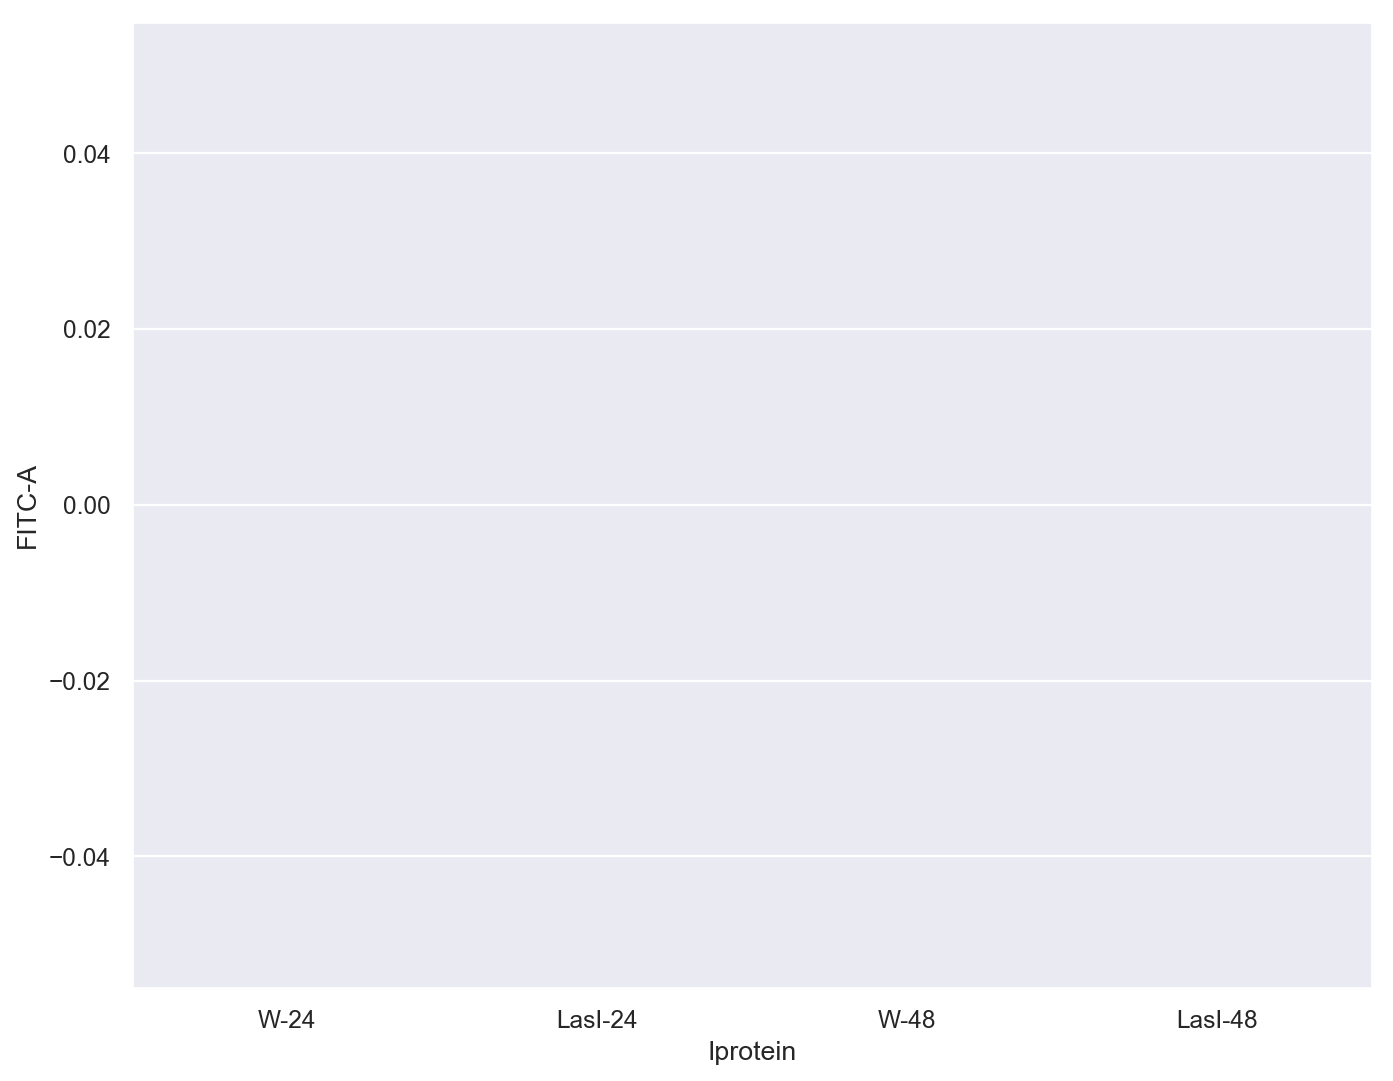

In [56]:
mfi = data.groupby(['Rprotein','Iprotein'])['FITC-A'].median().reset_index()
sns.set(font_scale=1.0)
f, ax = plt.subplots(figsize=(10,8))

#sns.pointplot(x='Rprotein',y='FITC-A',hue='Iprotein',data=mfi)
sns.barplot(x='Iprotein',y='FITC-A',data=mfi,order=['W-24','LasI-24','W-48','LasI-48'],ci=85)


f.savefig('LasR_LasI_coculture.png',dpi=600, transparent=True)

STOP HERE